# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (aoi) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull dem over the aoi. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (dem) (_optional_): used to extract elevations over the aoi and for each snowline. If no dem is provided, the ASTER Global dem will be loaded through GEE. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'RGI60-02.16912'
# path to snow-cover-mapping/ - Make sure you include a "/" at the end
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to folder containing AOI files
aoi_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/' + site_name + '/AOIs/'
# AOI file name
aoi_fn = site_name + '_outline.shp' 
# path to folder containing dem raster file
# Note: set dem_fn=None if you want to use the Arcticdem or NASAdem via Google Earth Engine
dem_path = aoi_path + '../DEMs/'
# DEM file name
dem_fn = None 
# path for output images
out_path = aoi_path + '../imagery/'
# path to PlanetScope images
# Note: set ps_im_path=None if not using PlanetScope
ps_im_path = None #out_path + 'PlanetScope/raw_images/'
# path for output figures
figures_out_path = aoi_path + '../figures/'

# -----Define image search filters
date_start = '2013-01-01'
date_end = '2022-12-01'
month_start = 5
month_end = 10
cloud_cover_max = 70

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest setting mask_clouds = False
mask_clouds = True

# -----Determine image download, clipping & plotting settings
# Note: if im_download = False, but images over the aoi exceed GEE limit,
# images must be downloaded regardless.
im_download = True  # = True to download all satellite images by default
plot_results = True # = True to plot figures of results for each image where applicable
crop_to_aoi = True # = True to crop images to aoi before calculating SCA
save_outputs = True # = True to save SCAs and snowlines to file
save_figures = True # = True to save output figures to file
verbose = True # = True to output details for each image during each step
skip_clipped = False # = True to skip PlanetScope images where bands appear "clipped", i.e. max(blue) < 0.8

#######################

# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt, dates
import matplotlib
import rasterio as rio
import geopandas as gpd
import pandas as pd
import sys
import ee
import geedim as gd
import json
from tqdm.auto import tqdm
from joblib import dump, load
from shapely.geometry import MultiPolygon, Polygon
import dask.bag as db
from dask.diagnostics import ProgressBar
import warnings
warnings.simplefilter("ignore")

# -----Set paths for output files
s2_toa_im_path = os.path.join(out_path, 'Sentinel-2_TOA')
s2_sr_im_path = os.path.join(out_path, 'Sentinel-2_SR')
l_im_path = os.path.join(out_path, 'Landsat')
ps_im_masked_path = os.path.join(out_path, 'PlanetScope', 'masked')
ps_im_mosaics_path = os.path.join(out_path, 'PlanetScope', 'mosaics')
im_classified_path = os.path.join(out_path, 'classified')
snowlines_path = os.path.join(out_path, 'snowlines')

# -----Add path to functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import pipeline_utils as f

# -----Load dataset dictionary
dataset_dict_fn = os.path.join(base_path, 'inputs-outputs', 'datasets_characteristics.json')
dataset_dict = json.load(open(dataset_dict_fn))

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [2]:
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except: 
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

#### Load AOI and DEM

Optimal utm CRS = EPSG:32612
No ArcticDEM coverage, using NASADEM


RGI60-02.16912_NASADEM_clip.tif: | | 0.00/202k (raw) [  0.0%] in 00:00 (eta:    

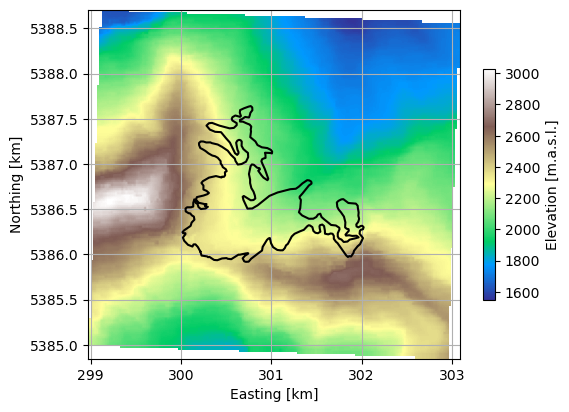

In [3]:
# -----Load AOI as gpd.GeoDataFrame
aoi = gpd.read_file(os.path.join(aoi_path, aoi_fn))
# reproject the AOI to WGS84 to solve for the optimal utm zone
aoi_wgs = aoi.to_crs('EPSG:4326')
aoi_wgs_centroid = [aoi_wgs.geometry[0].centroid.xy[0][0],
                    aoi_wgs.geometry[0].centroid.xy[1][0]]
# grab the optimal utm zone EPSG code
epsg_utm = f.convert_wgs_to_utm(aoi_wgs_centroid[0], aoi_wgs_centroid[1])
print('Optimal utm CRS = EPSG:' + str(epsg_utm))
# reproject AOI to the optimal utm zone
aoi_utm = aoi.to_crs('EPSG:'+epsg_utm)

# -----Load DEM as Xarray DataSet
if dem_fn is None:
    # query GEE for DEM
    dem = f.query_gee_for_dem(aoi_utm, base_path, site_name, dem_path)
else:
    # load DEM as xarray DataSet
    dem = xr.open_dataset(os.path.join(dem_path, dem_fn))
    dem = dem.rename({'band_data': 'elevation'})
    # set no data values to NaN
    dem = xr.where((dem > 1e38) | (dem <= -9999), np.nan, dem)
    # reproject the DEM to the optimal utm zone
    dem = dem.rio.reproject('EPSG:'+str(epsg_utm)).rio.write_crs('EPSG:'+str(epsg_utm))

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(dem.elevation.data, cmap='terrain', 
          extent=(np.min(dem.x.data)/1e3, np.max(dem.x.data)/1e3, np.min(dem.y.data)/1e3, np.max(dem.y.data)/1e3))
if type(aoi_utm.geometry[0])==Polygon:
    ax.plot([x/1e3 for x in aoi_utm.geometry[0].exterior.coords.xy[0]],
            [y/1e3 for y in aoi_utm.geometry[0].exterior.coords.xy[1]], '-k')
elif type(aoi_utm.geometry[0])==MultiPolygon:
    [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
            [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in aoi_utm.geometry[0].geoms]
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m.a.s.l.]')
plt.show()

## 1. Sentinel-2 TOA imagery

In [ ]:
# -----Query GEE for imagery (and download to s2_toa_im_path if necessary)
dataset = 'Sentinel-2_TOA'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, date_start, date_end, month_start, 
                                  month_end, cloud_cover_max, mask_clouds, s2_toa_im_path, im_download)

Querying GEE for Sentinel-2_TOA imagery...
No image downloads necessary, Sentinel-2_TOA images over the AOI are within the GEE limit.


  0%|          | 0/180 [00:00<?, ?it/s]

Made directory for image downloads: /Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/RGI60-02.16912/AOIs/../imagery/Sentinel-2_TOA


Sentinel-2_TOA_20151005_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160502_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160701_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160721_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160728_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160817_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160830_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20160926_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20161029_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170504_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170606_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170626_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170716_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170718_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170723_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170731_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170807_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170812_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170825_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170827_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170921_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20170929_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20171004_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20171026_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180512_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180514_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180519_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180522_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180527_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180603_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180606_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180608_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180621_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180706_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180708_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180711_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180713_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

Sentinel-2_TOA_20180716_MOSAIC.tif: | | 0.00/1.94M (raw) [  0.0%] in 00:00 (eta:

In [ ]:
# -----Check whether images were found
if type(im_list)==str: 
    print('No images found to classify, quitting...')
else:

    # -----Load trained classifier and feature columns
    clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_classifier_all_sites.joblib')
    clf = load(clf_fn)
    feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_feature_columns.json')
    feature_cols = json.load(open(feature_cols_fn))

    # -----Apply pipeline to list of images
    # Convert list of images to dask bag
    im_bag = db.from_sequence(im_list)
    # Create processor with appropriate function arguments
    def create_processor(im_xr):
        snowline_df = f.apply_classification_pipeline(im_xr, dataset_dict, dataset, site_name, im_classified_path, snowlines_path,
                                                      aoi_utm, dem, epsg_utm, clf, feature_cols, crop_to_aoi, figures_out_path,
                                                      plot_results, verbose)
        return snowline_df
    # Apply batch processing
    with ProgressBar():
        # prepare bag for mapping
        im_bag_results = im_bag.map(create_processor)
        im_bag_results.compute()
        

## 2. Sentinel-2 SR imagery

In [ ]:
# -----Query GEE for imagery and download to s2_sr_im_path if necessary
dataset = 'Sentinel-2_SR'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, date_start, date_end, month_start, 
                                  month_end, cloud_cover_max, mask_clouds, s2_sr_im_path, im_download)

In [ ]:
# -----Check whether images were found
if type(im_list)==str: 
    print('No images found to classify, quitting...')
else:

    # -----Load trained classifier and feature columns
    clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_classifier_all_sites.joblib')
    clf = load(clf_fn)
    feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_feature_columns.json')
    feature_cols = json.load(open(feature_cols_fn))

    # -----Apply pipeline to list of images
    # Convert list of images to dask bag
    im_bag = db.from_sequence(im_list)
    # Create processor with appropriate function arguments
    def create_processor(im_xr):
        snowline_df = f.apply_classification_pipeline(im_xr, dataset_dict, dataset, site_name, im_classified_path, snowlines_path,
                                                      aoi_utm, dem, epsg_utm, clf, feature_cols, crop_to_aoi, figures_out_path,
                                                      plot_results, verbose)
        return snowline_df
    # Apply batch processing
    with ProgressBar():
        # prepare bag for mapping
        im_bag_results = im_bag.map(create_processor)
        im_bag_results.compute()


## 3. Landsat 8/9 SR imagery

In [ ]:
# -----Query GEE for imagery (and download to l_im_path if necessary)
dataset = 'Landsat'
im_list = f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, date_start, date_end, month_start, month_end,
                                  cloud_cover_max, mask_clouds, l_im_path, im_download)

In [ ]:
# -----Check whether images were found
if type(im_list)==str: 
    print('No images found to classify, quitting...')
else:

    # -----Load trained classifier and feature columns
    clf_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_classifier_all_sites.joblib')
    clf = load(clf_fn)
    feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_feature_columns.json')
    feature_cols = json.load(open(feature_cols_fn))

    # -----Apply pipeline to list of images
    # Convert list of images to dask bag
    im_bag = db.from_sequence(im_list)
    # Create processor with appropriate function arguments
    def create_processor(im_xr):
        snowline_df = f.apply_classification_pipeline(im_xr, dataset_dict, dataset, site_name, im_classified_path, snowlines_path,
                                                      aoi_utm, dem, epsg_utm, clf, feature_cols, crop_to_aoi, figures_out_path,
                                                      plot_results, verbose)
        return snowline_df
    # Apply batch processing
    # with ProgressBar():
    # prepare bag for mapping
    im_bag_results = im_bag.map(create_processor)
    im_bag_results.compute()

## 4. PlanetScope SR imagery

In [ ]:
if not ps_im_path:
    print('Variable ps_im_path must be specified to run the PlanetScope classification pipeline, exiting...')
else:

    dataset = 'PlanetScope'

    # -----Read surface reflectance image file names
    os.chdir(ps_im_path)
    im_fns = sorted(glob.glob('*SR*.tif'))

    # ----Mask clouds and cloud shadows in all images
    plot_results = False
    if mask_clouds:
        print('Masking images using cloud bitmask...')
        for im_fn in tqdm(im_fns):
            f.planetscope_mask_image_pixels(ps_im_path, im_fn, ps_im_masked_path, save_outputs, plot_results)
    # read masked image file names
    os.chdir(ps_im_masked_path)
    im_masked_fns = sorted(glob.glob('*_mask.tif'))

    # -----Mosaic images captured within same hour
    print('Mosaicking images captured in the same hour...')
    if mask_clouds:
        f.planetscope_mosaic_images_by_date(ps_im_masked_path, im_masked_fns, ps_im_mosaics_path, aoi_utm)
        print(' ')
    else:
        f.planetscope_mosaic_images_by_date(ps_im_path, im_fns, ps_im_mosaics_path, aoi_utm)
        print(' ')

        # -----Adjust image radiometry
        im_adj_list = []
        # read mosaicked image file names
        os.chdir(ps_im_mosaics_path)
        im_mosaic_fns = sorted(glob.glob('*.tif'))
        # create polygon(s) of the top and bottom 20th percentile elevations within the aoi
        polygons_top, polygons_bottom = f.create_aoi_elev_polys(aoi_utm, dem)
        # loop through images
        for im_mosaic_fn in tqdm(im_mosaic_fns):

            # -----Open image mosaic
            im_da = xr.open_dataset(ps_im_mosaics_path + im_mosaic_fn)
            # determine image date from image mosaic file name
            im_date = im_mosaic_fn[0:4] + '-' + im_mosaic_fn[4:6] + '-' + im_mosaic_fn[6:8] + 'T' + im_mosaic_fn[
                                                                                                    9:11] + ':00:00'
            im_dt = np.datetime64(im_date)
            print(im_date)

            # -----Adjust radiometry
            im_adj, im_adj_method = f.planetscope_adjust_image_radiometry(im_da, im_dt, polygons_top, polygons_bottom,
                                                                          dataset_dict, skip_clipped)
            if type(im_adj) == str:  # skip if there was an error in adjustment
                continue
            else:
                im_adj_list.append(im_adj)

        # -----Load trained classifier and feature columns
        clf_fn = os.path.join(base_path, 'inputs-outputs', 'PlanetScope_classifier_all_sites.joblib')
        clf = load(clf_fn)
        feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'PlanetScope_feature_columns.json')
        feature_cols = json.load(open(feature_cols_fn))

        # -----Apply pipeline to list of images
        # Convert list of images to dask bag
        im_bag = db.from_sequence(im_list)
        # Create processor with appropriate function arguments
        def create_processor(im_xr):
            snowline_df = f.apply_classification_pipeline(im_xr, dataset_dict, dataset, site_name, im_classified_path,
                                                          snowlines_path,
                                                          aoi_utm, dem, epsg_utm, clf, feature_cols, crop_to_aoi,
                                                          figures_out_path,
                                                          plot_results, verbose)
            return snowline_df
        # Apply batch processing
        with ProgressBar():
            # prepare bag for mapping
            im_bag_results = im_bag.map(create_processor)
            im_bag_results.compute()